In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Notebook Setup

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    # MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/TFT_baseline"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    # MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"
    MY_HOME_ABS_PATH = "/home/ec2-user/SageMaker/root/co2-flux-hourly-gpp-modeling"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
#MY_HOME_ABS_PATH = "/Users/jetcalz07/Desktop/MIDS/W210_Capstone/co2-flux-hourly-gpp-modeling"
# MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling"
MY_HOME_ABS_PATH =  "/content/drive/MyDrive/TFT_baseline"

## Import Modules

In [4]:
!pip install azure.storage.blob 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.8/387.8 KB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 5.0 MB/s eta 0:00:00


In [5]:
!pip install pytorch_lightning 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.8 MB/s eta 0:00:00


In [6]:
!pip install pytorch_forecasting


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 16.0 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1

In [7]:
from azure.storage.blob import BlobServiceClient
from collections import defaultdict
from io import BytesIO
import os.path
import json

class AzStorageClient:
    def __init__(self, cred_file):
        self.blob_svc_client = None
        self.container_client_list = defaultdict(str)
        if os.path.exists(cred_file):
            connect_str = ""
            with open(cred_file, "rb") as f:
                data = json.load(f)
                connect_str = data['connectionstr']
                self.blob_svc_client = BlobServiceClient.from_connection_string(connect_str)
                tokens = connect_str.split(';')
                for t in tokens:
                  if "AccountName=" in t:
                    self.AccountName = t[len("AccountName="):]
                  elif "AccountKey=" in t:
                    self.AccountKey = t[len("AccountKey="):]
        else:
            print("ERROR: {cred_file} not found")
    
    def getSparkSessionKeys(self):
      return [f'fs.azure.account.key.{self.AccountName}.blob.core.windows.net',  self.AccountKey, self.AccountName]

    def createContainer(self, container_name):
        if self.blob_svc_client:
            self.blob_svc_client.create_container(container_name)
            print(f"Container '{container_name}' created.")
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")

    def listBlobs(self, container_name):
        if self.blob_svc_client:
            if not self.container_client_list[container_name]:
                self.container_client_list[container_name] = self.blob_svc_client.get_container_client(container= container_name)
            blob_list = self.container_client_list[container_name].list_blobs()
            return blob_list
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")

    def uploadBlob(self, container_name, blob_name, data, overwrite=False, verbose=True):
        if self.blob_svc_client:
            blob_cleint = self.blob_svc_client.get_blob_client(container=container_name, blob=blob_name)
            blob_cleint.upload_blob(data, overwrite=overwrite)
            if verbose:
                print(f'File uploaded to {container_name}/{blob_name}')
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")
    
    def downloadBlob(self, container_name, blob_name):
        if self.blob_svc_client:
            if not self.container_client_list[container_name]:
                self.container_client_list[container_name] = self.blob_svc_client.get_container_client(container= container_name)
            
            return self.container_client_list[container_name].download_blob(blob_name).readall()
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")
    
    def downloadBlob2Stream(self, container_name, blob_name):
        if self.blob_svc_client:
            if not self.container_client_list[container_name]:
                self.container_client_list[container_name] = self.blob_svc_client.get_container_client(container= container_name)
            
            stream = BytesIO()
            self.container_client_list[container_name].download_blob(blob_name).readinto(stream)
            return stream
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")
    
    def deleteBlob(self, container_name, blob_name, verbose=True):
        if self.blob_svc_client:
            blob_client = self.blob_svc_client.get_blob_client(container=container_name, blob=blob_name)
            blob_client.delete_blob()
            if verbose:
                print(f'{container_name}/{blob_name} deleted')
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")
    

In [8]:
import os
import sys
import random
import pandas as pd
import numpy as np

from datetime import datetime 
from io import BytesIO
from tqdm import tqdm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

# if ("UseSpark" in os.environ) or (os.environ.get('UseSpark') == "true"):
#   from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
#   from pyspark.sql.functions import col

from IPython.display import display
# from CloudIO.AzStorageClient import AzStorageClient
# import AzStorageClient

def get_min_max(df):
  return (df.min(), df.max())

def get_min_max_datetime(df):
  return (pd.to_datetime(df).min(), pd.to_datetime(df).max())

def is_leap_year(year):
  return year%4 == 0 ;

def data_cleanup(data_dir, site_id_file_df, target, target_qc, features):
  data_df = None
  # qc_flag_dtype = CategoricalDtype([0, 1, 2, 3], ordered=True)
  qc_flags_features = [s for s in features if "_QC" in s]

  # Iterate through each site:
  for i, r in site_id_file_df.iterrows():        
    if not r.filename or type(r.filename) != type(""):
      print(f'\nERROR: {r.site_id} is mssing hourly data.')
      continue

    # Get only `features` from file
    local_filename = data_dir + os.sep + r.filename
    site_df = pd.read_csv(local_filename, usecols = [target, target_qc] + features)
    site_df['datetime'] = pd.to_datetime(site_df['datetime'])
    site_df['date'] = pd.to_datetime(site_df['date'])
    site_df['minute'] = site_df['datetime'].dt.minute
    if len(qc_flags_features) != 0:
      site_df[qc_flags_features] = site_df[qc_flags_features].astype('int')
    site_df['site_id'] = r.site_id

    # Add time index columns
    site_df = add_time_index(site_df, 'datetime', '30T')

    # Remove zero or negative SW
    site_df.drop(site_df[site_df['SW_IN_ERA'] <= 0].index, inplace = True)

    # Drop rows with NAs for Target Variable
    site_df.dropna(subset=[target], axis=0, inplace=True)

    # Drop rows with bad NEE_VUT_REF_QC (aka bad GPP records)
    site_df.drop(site_df[site_df[target_qc] == 3].index, inplace = True)
    site_df.drop([target_qc], axis=1, inplace=True)

    # Drop rows with any NA
    site_df.dropna(axis=0, inplace=True)

    print(f"{r.site_id}: {site_df.shape}")
    if type(data_df) == type(None):
      data_df = site_df
    else:
      data_df = pd.concat([data_df, site_df])
          
  return data_df

def merge_site_metadata(data_df, site_metadata_df):
  data_df = data_df.merge(site_metadata_df, how='left', left_on='site_id', right_on='site_id')
  return data_df

def check_and_drop_na(data_df):
  if data_df.isna().sum().sum() > 0:
    print("Data has NA.")
    display(pd.DataFrame(data_df.isna().sum()).T)
    data_df.dropna(axis=0, inplace=True)
  else:
    print("Datas has no NA.")

def add_time_index(data_df, time_col, duration):
  resampled_df = data_df.sort_values(by=[time_col])
  resampled_df.set_index(time_col, inplace=True)
  resampled_df = resampled_df.resample(duration).mean()
  resampled_df = resampled_df.reset_index()
  resampled_df.index.name='timestep_idx'
  resampled_df = resampled_df.reset_index()
  data_df = data_df.merge(resampled_df[[time_col, 'timestep_idx']], how='left', on='datetime')
  return data_df


class PrepareMonthlyData:
    def __init__(self, included_features, monthly_data_input_fname, data_dir):
        self.included_features =included_features
        self.data_dir = data_dir
        self.monthly_data_input_fname = monthly_data_input_fname
        self.month_df = pd.read_csv(self.monthly_data_input_fname, usecols=self.included_features)
        self.month_df['date'] = pd.to_datetime(self.month_df['TIMESTAMP'],  format="%Y%m")


    def to_datetime(self, row):
        return pd.to_datetime(f'{row.year}{row.month:02}', format='%Y%m')


    def knn_impute(self, df, knn_imp_cols, k, weights):
        # Fit and transform the data using KNNImputer, format as DF
        inds = df.index.copy()
        df_subcols = df[knn_imp_cols].copy()
        df_subcols = df_subcols.dropna(axis=1, how='all')

        # Execute imputation
        imputer = KNNImputer(n_neighbors=k, weights=weights)
        imputed_group = imputer.fit_transform(df_subcols)
        imputed_group = pd.DataFrame(imputed_group, columns=df_subcols.columns, index=inds)

        # Fill NA in initial site/group df
        df.fillna(imputed_group, inplace=True)

        return df


    def impute(self, impute_method, resample_monthly, knn_imp_cols=None, k=None, weights=None, c=-1):
        # Resample to fill in missing month gaps, and interpolate values at site-level
        monthly_df = None

        # Subset month_df to only sites with hourly records available
        available_sites = [x[-10:-4] for x in os.listdir(self.data_dir)]
        init_sites = len(self.month_df['SITE_ID'].unique())
        self.month_df = self.month_df.loc[self.month_df['SITE_ID'].isin(available_sites)]
        print(f"# sites dropped bc not available in data_dir: {init_sites - len(self.month_df['SITE_ID'].unique())}")
        
        # Loop through hourly site data to determine which months are present
        for i, s in tqdm(enumerate(self.month_df['SITE_ID'].unique())):
            # Get monthly data for site
            site_month = self.month_df[self.month_df['SITE_ID'] == s].copy()
            site_month.reset_index(drop = True, inplace=True)
            site_month['gap_flag_month'] = int(0)

            if resample_monthly:
                # Get start and end range for given site <------------------------- CREATE DF NEXT TIME TO SAVE TIME (30 seconds per run)
                site_file = f'data_full_half_hourly_raw_v0_1_{s}.csv'
                site_hr_df = pd.read_csv(f"{self.data_dir}/{site_file}", usecols=['SITE_ID', 'datetime', 'year', 'month'])
                dates = [d for d in pd.date_range(start=site_hr_df['datetime'].min(), end=site_hr_df['datetime'].max(), freq='M')]

                # Create range of monthly dates from beginning of minimum month to beginning of next month after maximum month
                site_hr_df['datetime'] = pd.to_datetime(site_hr_df['datetime'])
                min_datetime = site_hr_df['datetime'].min()
                max_datetime = site_hr_df['datetime'].max()
                dates = pd.date_range(start=min_datetime.replace(day=1), end=max_datetime.replace(day=1) + pd.offsets.MonthBegin(1), freq='MS')

                # Create dataframe
                site_hr_df = pd.DataFrame({'datetime': dates})
                site_hr_df['year'] = site_hr_df['datetime'].dt.year
                site_hr_df['month'] = site_hr_df['datetime'].dt.month
                site_hr_df['SITE_ID'] = s

                # Resample montlhly data to get the months required in hourly data
                pft = site_month['MODIS_PFT'][0] # retain PFT to fill new rows
                igbp = site_month['MODIS_IGBP'][0] # retain PFT to fill new rows
                site_month = pd.merge(site_hr_df, site_month, how='left', on =['SITE_ID', 'year', 'month'])
                site_month['MODIS_PFT'] = pft
                site_month['MODIS_IGBP'] = igbp
                site_month['SITE_ID'] = s
                site_month['gap_flag_month'].fillna(int(1), inplace=True)

            # Fill in known values for new/resampled month-level rows
            site_month['datetime'] = site_month.apply(self.to_datetime, axis=1)
            site_month.set_index('datetime', inplace=True)
            site_month.drop(columns='TIMESTAMP', inplace=True)
            site_month.drop(columns='date', inplace=True)

            # If any new months added by resample, interpolate gap values at site-level
            if site_month.isna().sum().sum() != 0: 
                if impute_method == 'interpolate':
                    site_month.interpolate(method='linear', limit_direction='both', inplace=True)

                elif impute_method == 'knn':
                    nan_cols = site_month.columns[site_month.isna().all()].tolist()
                    site_month = self.knn_impute(site_month, knn_imp_cols, k, weights)
                    if len(nan_cols) > 0:
                        print(f'{s} has column(s) with only NAN: {nan_cols}')
                        for c in nan_cols:
                            site_month[c] = np.nan
                            
                elif impute_method == 'constant':
                    monthly_df = self.month_df.fillna(c)

            # Concat site_month to monthly_df
            if type(monthly_df) == type(None):
                monthly_df = site_month
            else:
                monthly_df = pd.concat([monthly_df, site_month])

        # if any site had 100% missing for a feature, impute these using global data
        if monthly_df.isna().sum().sum() != 0:
            print("Imputing values where site has 100 percent of feature missing")
            print(f"# of NA features before global impute: {monthly_df.isna().sum().sum()}")
            if impute_method == 'interpolate':
                monthly_df.interpolate(method='linear', limit_direction='both', inplace=True)

            elif impute_method == 'knn':
                monthly_df = self.knn_impute(monthly_df, knn_imp_cols, k, weights)

            elif impute_method == 'constant':
                monthly_df = self.monthly_df.fillna(c)

            print(f"# of NA features after global impute: {monthly_df.isna().sum().sum()}")

        return monthly_df


    def run(self, impute=False, impute_method=None, resample_monthly=False, knn_imp_cols=None, k=None, weights=None, c=-1):
        # Hanlde missing values
        if impute:
            print(f"Impute method: {impute_method}")
            print(f"Resampling and gap filling missing months: {resample_monthly}")
            monthly_df = self.impute(impute_method, resample_monthly, knn_imp_cols, k, weights, c)
        else:
            print("Not gap filling or filling NAs, leave be")
            available_sites = [x[-10:-4] for x in os.listdir(self.data_dir)]
            self.month_df = self.month_df.loc[self.month_df['SITE_ID'].isin(available_sites)]
            monthly_df = self.month_df.copy()
            
        # Confirm No NAS
        if monthly_df.isna().sum().sum() == 0:
            print("Confirmed: No NA values remain")
        elif type(impute_method) != type(None):
            print("ISSUE: SOME NA VALUES REMAIN - INVESTIGATE")
            monthly_df.isna().sum()

        return monthly_df
        

class PrepareAllSitesHourly:
    def __init__(self, site_metadata_filename, monthly_data_filename, train_sites, val_sites, test_sites, 
                hourly_features, metadata_features, target_variable_qc, target_variable, data_dir):
        self.site_metadata_filename = site_metadata_filename
        self.monthly_data_filename = monthly_data_filename
        self.train_sites = train_sites
        self.val_sites = val_sites
        self.test_sites = test_sites
        if train_sites is not None and val_sites is not None and test_sites is not None:
          self.all_sites = train_sites + val_sites + test_sites
        else:
          self.all_sites = None
        self.hourly_features = hourly_features
        self.metadata_features = metadata_features
        self.target_variable_qc = target_variable_qc
        self.target_variable = target_variable
        self.data_dir = data_dir

    def add_time_index(self, df, time_col, duration, site_id):
        df['gap_flag_hour'] = int(0)
        df.sort_values(time_col, inplace=True)
        df.set_index(time_col, inplace=True)
        df = df.resample(duration).first()
        df = df.reset_index()
        df['gap_flag_hour'].fillna(int(1), inplace=True)

        # Fix time records that are NA for new rows
        df['year'] = df['datetime'].dt.year.astype(int)
        df['month'] = df['datetime'].dt.month.astype(int)
        df['day'] = df['datetime'].dt.day.astype(int)
        df['hour'] = df['datetime'].dt.hour.astype(int)
        df['date'] = df['datetime'].dt.date
        df['site_id'] = site_id

        return df


    def knn_impute(self, df, imp_cols, k, weights, n_fit=20000):
        # Init Imputer
        imputer = KNNImputer(n_neighbors=k, weights=weights)

        # Get subset of rows to speed up impute time (instead of fitting on every single record)
        df_subcols = df[imp_cols].copy()
        na_mask = df_subcols.isna().any(axis=1)
        na_rows = df_subcols[na_mask]
        nan_cols = []
        imputed_group_columns = df_subcols.columns

        # If there are at least 10k rows that don't have NA, use them to fit imputer (saves time)
        if (len(df) - len(na_rows)) > 10000:
            not_na_rows = df_subcols.dropna()
            not_na_rows = not_na_rows[na_rows.columns]
            not_na_rows = not_na_rows.sample(n=np.min([n_fit, len(not_na_rows)]))
            imputer.fit(not_na_rows)
            imputed_group = imputer.transform(na_rows)
        else:
            nan_cols = na_rows.columns[na_rows.isna().all()].tolist()
            na_rows = na_rows.dropna(axis=1, how='all')
            imputed_group_columns = na_rows.columns
            imputed_group = imputer.fit_transform(na_rows)

        imputed_group = pd.DataFrame(imputed_group, columns=imputed_group_columns, index=na_rows.index)
        if len(nan_cols) > 0:
            print(f'  Column(s) with only NAN: {nan_cols}')
            for c in nan_cols:
                imputed_group[c] = np.nan

        # Reinsert NA rows
        df_subcols.loc[na_mask] = imputed_group

        # Fill NA in initial site/group df
        df.fillna(df_subcols, inplace=True)

        return df

    
    def check_imputation(self, df_init,  df_imputed):
        # Drop NA rows from both (using indices) confirm they are same df now
        drop_na = df_init.dropna(how='any')
        drop_imp = df_imputed.loc[drop_na.index, ]
        drop_na.reset_index(inplace=True, drop=True)
        drop_imp.reset_index(inplace=True, drop=True)
        if not drop_na.equals(drop_imp):
            print("IMPUTATION ERROR: Non-NA values were affected in imputation")

        # Check that 50 rows that initial had NA are the same in non-NA cols
        na_inds = df_init.loc[df_init.isna().any(axis=1), ].index
        errors = 0
        for ind in na_inds[:50]:
            check_ind = pd.concat([df_init.iloc[ind], df_imputed.iloc[ind]], axis=1).dropna()
            check_ind.columns = ['initial', 'post_imp']
            if not check_ind['initial'].equals(check_ind['post_imp']):
                errors += 1
                print(ind)

        if errors != 0:
            print("IMPUTATION ERROR: Non-NA values in rows with NA were affected by imputation")

        # DF length is the same 
        if len(df_init) != len(df_imputed):
            print("IMPUTATION ERROR: Post imputation df has different row count than initial df")


    def filter_date_range(self, df, start_date, end_date, time_col, missing_thresh=0.2):
        df.set_index(time_col, inplace=True)
        filtered_df = df.loc[start_date:end_date].copy()

        # Remove sites without at least one year of records
        if len(filtered_df) < 365*24:
            return None
        else:
            # Remove sites that have > 20% gaps in sequence
            first_date = filtered_df.index.min()
            last_date = filtered_df.index.max()
            total_expected_count = len(pd.date_range(start=first_date, end=last_date, freq='H'))
            missing_percentage = (total_expected_count - len(filtered_df)) / total_expected_count

            if missing_percentage > missing_thresh:
                return None
            else:
                filtered_df.reset_index(inplace=True)
                return filtered_df
            

    def prep_metadata(self):
        site_metadata_df = pd.read_csv(self.site_metadata_filename, usecols = self.metadata_features)
        
        if self.all_sites is not None:
          site_metadata_df = site_metadata_df.loc[site_metadata_df['site_id'].isin(self.all_sites), ]
        
        site_metadata_df = site_metadata_df.loc[site_metadata_df['monthly_data_available']=='Yes', ] # <---- not including sites that have zero monthly data (ask team)
        site_metadata_df.reset_index(inplace=True, drop=True)
        return site_metadata_df


    def merge_site_metadata(self, data_df, site_metadata_df):
        site_metadata_df = site_metadata_df.drop(['filename', 'monthly_data_available'], axis=1)
        data_df = data_df.merge(site_metadata_df, how='left', left_on='site_id', right_on='site_id')
        print(f"Data size after after merged with site metadata: {data_df.shape}")

        if data_df.isna().sum().sum() != 0:
            print(f"Missing values after metadata merge {data_df.isna().sum().sum()} ")

        return data_df


    def merge_monthly_data(self, data_df):
        # Prep monthly
        monthly_df = pd.read_csv(self.monthly_data_filename)
        monthly_df.reset_index(inplace=True, drop=True)
        monthly_df[['year','month', 'MODIS_LC']] = monthly_df[['year','month', 'MODIS_LC']].astype('int')

        if monthly_df.isna().sum().sum() != 0:
            print(f"{monthly_df.isna().sum().sum()} missing values in monthly data")

        # Merge
        data_df = data_df.merge(monthly_df, how='left',
                        left_on =['site_id', 'year', 'month'],
                        right_on=['SITE_ID', 'year', 'month'])
        data_df.drop('SITE_ID', axis=1, inplace=True)
        print(f"Data size after after merged with monthly data: {data_df.shape}")

        if data_df.isna().sum().sum() != 0:
            print(f"{data_df.isna().sum().sum()} missing values introduced after monthly merge")

        return data_df
    

    def site_data_cleanup(self, site_metadata_df, imp_cols, resample, impute, impute_method,
                         impute_global, k, weights, n_fit, time_col, duration, start_date, end_date, missing_thresh=0.2, c=None):
        data_df = None
        num_records = 0
        available_site_count = 0
        retained_site_count = 0
        qc_flags_features = [s for s in self.hourly_features if "_QC" in s]

        # Global time index base
        global_time_index_base = datetime(1970, 1, 1, 0, 0, 0)

        ## SITE-LEVEL CLEANING -> LOOP & CONCATENATE
        for i, r in tqdm(site_metadata_df[['site_id','filename']].iterrows()):
          if not r.filename or type(r.filename) != type(""):
            print(f'SKIP: {r.site_id} is missing hourly data.')
            continue

          available_site_count += 1  

          # Prepare hourly site df
          local_filename = self.data_dir + os.sep + r.filename
          site_df = pd.read_csv(local_filename, usecols = [self.target_variable] + self.hourly_features)

          # Format columns
          site_df['datetime'] = pd.to_datetime(site_df['datetime'])
          site_df['date'] = pd.to_datetime(site_df['date'])
          site_df['minute'] = site_df['datetime'].dt.minute
          if len(qc_flags_features) != 0:
              site_df[qc_flags_features] = site_df[qc_flags_features].astype('int')
          site_df['site_id'] = r.site_id

          # Move from HH to H level
          site_df = site_df.loc[site_df['datetime'].dt.minute == 0, ].copy()
          site_df.drop('minute', axis=1, inplace=True)
            
          # Filter site date-range and drop sites without > 1 year and <20% gaps after trim
          if start_date is not None and end_date is not None:
            site_df = self.filter_date_range(site_df, start_date, end_date, time_col, missing_thresh)
          
          if site_df is None:
              print(f'SKIP: {r.site_id} does not have sufficient data in desired time period')
              continue
          else:
              retained_site_count += 1
              num_records += len(site_df)

          # Resample to add rows for missing timesteps, assign timestep_idx and "gap_flag"
          if resample:
              site_df = self.add_time_index(site_df, time_col, duration, site_id=r.site_id)
          else:
              site_df['gap_flag_hour'] = 0
              site_df.sort_values(time_col, inplace=True)
              site_df = site_df.reset_index()

          # Save site_df pre-imputation to check post-imputation (once per run, random site each time)
          if self.all_sites is not None:
            random_check = random.randint(0, len(self.all_sites))
          else:
            random_check = random.randint(0, site_metadata_df['site_id'].unique().shape[0])
          
          if i == random_check:   
              site_df_pre_imp = site_df.copy()
          
          # Impute missing values at site-level, otherwise fillna w/ -1 at very end
          if (impute) & (site_df.isna().sum().sum() != 0):
              if impute_method=='ffill': # select most recent record
                  site_df.sort_values(time_col, ascending=True, inplace=True)
                  site_df.fillna(method="ffill", inplace=True)
              elif impute_method=='knn': # use KNNImputer
                  nan_cols = site_df.columns[site_df.isna().all()].tolist()
                  site_df = self.knn_impute(site_df, imp_cols, k, weights, n_fit)
                  if len(nan_cols) > 0:
                      print(f'{r.site_id} has column(s) with only NAN: {nan_cols}')
                      for c in nan_cols:
                          site_df[c] = pd.NA
              elif impute_method=='constant':
                  site_df[imp_cols] = site_df[imp_cols].fillna(c)

          if i == random_check:
              self.check_imputation(site_df_pre_imp, site_df)
          
          # Create local timestep_idx
          site_df.sort_values(time_col, ascending=True, inplace=True)
          site_df['timestep_idx_local'] = range(len(site_df))

          # Create global timestamp inds
          site_df['timestep_idx_global'] = (site_df[time_col]- global_time_index_base).\
                                            apply(lambda x: int(x.total_seconds() / 3600))

          # Concatenate site_dfs together into global data_df
          print(f'{i+1}. {r.site_id}: {site_df.shape}')
          if type(data_df) == type(None):
              data_df = site_df
          else:
              data_df = pd.concat([data_df, site_df])
        # End all-site loop

        ## Global Data-DF Cleanup
        # Order cols + sort
        data_df.sort_values(['site_id', time_col], ascending=True, inplace=True)

        # Print stats
        print(f"Initial records: {num_records}, Final records after resampling + gap-filling: {len(data_df)}")
        print(f"Total retained sites: {retained_site_count}/{available_site_count} = {retained_site_count/available_site_count:.2f}")

        # Handle remaining missing data (if 100% of feature missing for one site)
        print(f"Missing values after site-level imputation: {data_df.isna().sum().sum()}")
        if (impute_global) & (data_df.isna().sum().sum() != 0):
            if impute_method=='ffill': # select most recent record
                data_df.sort_values(time_col, ascending=True, inplace=True)
                data_df.fillna(method="ffill", inplace=True)
                data_df.fillna(method="bfill", inplace=True) # in rare case of missing first record
                
            elif impute_method=='knn': # use KNNImputer
                data_df = self.knn_impute(data_df, imp_cols, k, weights, n_fit)

            elif impute_method=='constant':
                data_df[imp_cols] = data_df[imp_cols].fillna(c)
        else:
            print("Not imputing missing values at global level")
        print(f"Missing values after global-level imputation: {data_df.isna().sum().sum()}")

        return data_df
    

    def all_sites_all_sources(self, imp_cols, resample, impute, impute_method, impute_global, k,
                            weights, n_fit, time_col, duration, start_date, end_date, missing_thresh, c):
        
        site_metadata_df = self.prep_metadata()
        
        if self.all_sites is not None:
          sites_missing_monthly = [s for s in self.all_sites if s not in site_metadata_df['site_id'].values]
          if len(sites_missing_monthly):
            print(f'Sites with missing monthly data: {sites_missing_monthly}')

        data_df = self.site_data_cleanup(site_metadata_df, imp_cols, resample, impute, impute_method, 
                                        impute_global, k, weights, n_fit, time_col, duration, start_date, end_date, missing_thresh, c)

        # Merge with site metadata and monthly data
        data_df = self.merge_site_metadata(data_df, site_metadata_df)
        data_df = self.merge_monthly_data(data_df)

        # Reorder columns
        features = data_df.columns.to_list()
        remove_cols = [self.target_variable, 'site_id', 'timestep_idx_local', 'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day', 'hour', 'gap_flag_hour', 'gap_flag_month']
        features = list(filter(lambda x: x not in remove_cols, features))
        data_df = data_df[([self.target_variable, 'site_id', 'timestep_idx_local', 'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day', 'hour'] + features + ['gap_flag_hour', 'gap_flag_month'])]

        return data_df

if ("UseSpark" in os.environ) or (os.environ.get('UseSpark') == "true"):
    class PySparkMLDataTransformer:
      def __init__(self, spark_session, train_sites, test_sites, \
                  data_file_path = None, data_df = None, ):
        
        self.spark_session = spark_session
        self.data_df = data_df 
        self.train_df = None 
        self.test_df = None 
        self.train_sites = train_sites
        self.test_sites = test_sites
        self.scaler = None

        if type(data_df) == type(None):
          if os.path.exists(data_file_path):
            self.data_df = self.spark_session.read.parquet(data_file_path)
            if '__index_level_0__' in self.data_df.columns:
              self.data_df = self.data_df.drop(*['__index_level_0__'])
          else:
            print(f"ERROR: {data_file_path} not found.")
        
        if 'date' in self.data_df.columns:
          self.data_df = self.data_df.drop(*['date'])
        print(f"Data loaded: {self.data_df.count()} rows x {len(self.data_df.columns)} columns.")
      
      def data_transform(self, categorical_cols, timestamp_cols, target_col):
        self.categorical_cols = categorical_cols
        self.timestamp_cols =  timestamp_cols
        self.target_col =  target_col

        # One-Hot Encoding
        string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=[x + "_Index" for x in categorical_cols]) 
        self.data_df = string_indexer.fit(self.data_df).transform(self.data_df)
        one_hot_encoder  = OneHotEncoder(inputCols=string_indexer.getOutputCols(), outputCols=[x + "_OHE" for x in categorical_cols])
        self.data_df = one_hot_encoder.fit(self.data_df).transform(self.data_df)
        self.data_df = self.data_df.drop(*string_indexer.getOutputCols())

        print(f"Data size after encoding: {self.data_df.count()} rows x {len(self.data_df.columns)} columns.")
        self.data_df.show(5, False)

        # Get Features
        features = self.data_df.columns
        features.remove(target_col)
        features.remove('site_id')
        for f in categorical_cols + timestamp_cols:
          features.remove(f)
        print(f"Features({len(features)}): {features}")

        # Assemable Data
        assembler = VectorAssembler(inputCols=features, outputCol="vectorized_features")
        self.data_df = assembler.transform(self.data_df)
        print(f"Data size after assembling: {self.data_df.count()} rows x {len(self.data_df.columns)} columns.")
        self.data_df.show(5, False)

        # Split into train and test sets
        train_df = self.data_df.filter(col('site_id').isin(self.train_sites))
        test_df = self.data_df.filter(col('site_id').isin(self.test_sites))
        print(f"Train data size: {train_df.count()} rows x {len(train_df.columns)} columns.")
        print(f"Test data size: {test_df.count()} rows x {len(test_df.columns)} columns.")

        print("Train data peak:")
        train_df.show(5, False)
        print("Test data peak:")
        test_df.show(5, False)

        # Normalize data
        self.scaler = MinMaxScaler(inputCol='vectorized_features', outputCol='features').fit(train_df)
        train_df = self.scaler.transform(train_df)
        test_df = self.scaler.transform(test_df)

        train_df = train_df.drop(*['vectorized_features'])
        test_df = test_df.drop(*['vectorized_features'])
        print(f"Train data size: {train_df.count()} rows x {len(train_df.columns)} columns.")
        print(f"Test data size: {test_df.count()} rows x {len(test_df.columns)} columns.")

        self.train_df = train_df
        self.test_df = test_df
        return (train_df, test_df)
      
      def upload_train_test_to_azure(self, az_cred_file, container, train_blob_name, val_blob_name, test_blob_name):
        # Initialize AzStorageClient 
        azStorageClient = AzStorageClient(az_cred_file)
        sessionkeys = azStorageClient.getSparkSessionKeys()
        self.spark_session.conf.set(sessionkeys[0],sessionkeys[1])

        # Upload train dataset
        train_blob_path = f"wasbs://{container}@{sessionkeys[2]}.blob.core.windows.net/{train_blob_name}"
        print(f"Uploading train dataset to {train_blob_path}...")
        self.train_df.write.format("parquet").mode("overwrite").save(train_blob_path)

        # Upload val dataset
        val_blob_name = f"wasbs://{container}@{sessionkeys[2]}.blob.core.windows.net/{val_blob_name}"
        print(f"Uploading train dataset to {val_blob_name}...")
        self.val_df.write.format("parquet").mode("overwrite").save(val_blob_name)

        # Upload test dataset
        test_blob_path = f"wasbs://{container}@{sessionkeys[2]}.blob.core.windows.net/{test_blob_name}"
        print(f"Uploading test dataset to {test_blob_path}...")
        self.test_df.write.format("parquet").mode("overwrite").save(test_blob_path)

class TFTDataTransformer:
  def __init__(self, train_sites, val_sites, test_sites, \
              data_file_path = None, data_df = None):
    
    self.data_df = data_df 
    self.train_sites = train_sites
    self.val_sites = val_sites
    self.test_sites = test_sites
    self.scaler = None

    # Load data df
    if type(data_df) == type(None):
      if os.path.exists(data_file_path):
        self.data_df = pd.read_parquet(data_file_path, engine='pyarrow')
      else:
        print(f"ERROR: {data_file_path} not found.")
    
    if 'date' in self.data_df.columns:
      self.data_df = self.data_df.drop(['date'], axis = 1)
    print(f"Data size: {self.data_df.shape}.")

  def get_test_train_raw(self):
    train_df = self.data_df[self.data_df['site_id'].isin(self.train_sites)]
    test_df  = self.data_df[self.data_df['site_id'].isin(self.test_sites)]
    print(f"Train data size: {train_df.shape}.")
    print(f"Test data size: {test_df.shape}.")

    self.train_df = train_df
    self.test_df = test_df
    return (train_df, test_df)

  def data_transform(self, categorical_cols, realNum_cols, cat_encode_type='label'):
    data_df = self.data_df
    print(f"Data size: {self.data_df.shape}.")

    # Encode the categorical columns
    if cat_encode_type == 'label':
      data_df[categorical_cols] = data_df[categorical_cols].apply(LabelEncoder().fit_transform)
    elif cat_encode_type == 'dummy':
      dummy_df = pd.get_dummies(data_df[categorical_cols])
      data_df = data_df.drop(columns=categorical_cols)
      data_df = pd.concat([data_df, dummy_df], axis=1)
    print(f"Data size after encoding: {data_df.shape}")
      
    # Split into train, val, and test sets
    train_df = data_df.loc[data_df['site_id'].isin(self.train_sites), ].copy()
    val_df = data_df.loc[data_df['site_id'].isin(self.val_sites), ].copy()
    test_df  = data_df.loc[data_df['site_id'].isin(self.test_sites), ].copy()
    print(f"Number of sites in df: {len(data_df['site_id'].unique())}")
    print(f"Train Sites: {train_df['site_id'].unique()}")
    print(f"Val Sites: {val_df['site_id'].unique()}")
    print(f"Test Sites: {test_df['site_id'].unique()}")

    # Normalize data
    print(f"Normalizing real features ({len(realNum_cols)})")
    scaler = StandardScaler().fit(train_df[realNum_cols])
    train_df.loc[:,realNum_cols] = scaler.transform(train_df[realNum_cols])
    val_df.loc[:,realNum_cols] = scaler.transform(val_df[realNum_cols])
    test_df.loc[:,realNum_cols] = scaler.transform(test_df[realNum_cols])

    # Save scaler object <--- later
    
    print(f"Train data size: {train_df.shape}.")
    print(f"Val data size: {val_df.shape}.")
    print(f"Test data size: {test_df.shape}.")  
    train_df.reset_index(inplace=True, drop=True)
    val_df.reset_index(inplace=True, drop=True)
    test_df.reset_index(inplace=True, drop=True)

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    return (train_df, val_df, test_df)

  def upload_train_test_to_azure(self, az_cred_file, container, train_blob_name, test_blob_name):
    # Initialize AzStorageClient 
    azStorageClient = AzStorageClient(az_cred_file)

    # Upload train dataset
    train_file = BytesIO()
    self.train_df.to_parquet(train_file, engine='pyarrow')
    train_file.seek(0)
    print(f"Uploading train dataset to {train_blob_name}...")
    azStorageClient.uploadBlob(container, train_blob_name, train_file, overwrite=True)

    # Upload test dataset
    test_file = BytesIO()
    self.test_df.to_parquet(test_file, engine='pyarrow')
    test_file.seek(0)
    print(f"Uploading test dataset to {test_blob_name}...")
    azStorageClient.uploadBlob(container, test_blob_name, test_file, overwrite=True)


In [9]:
# NEW
# MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling"

# Inmport Libraries
import os
os.chdir(MY_HOME_ABS_PATH)

import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import logging
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Tuple, Union
import tensorflow as tf
import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import statsmodels.api as sm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

import optuna
from optuna.integration import PyTorchLightningPruningCallback, TensorBoardCallback
import optuna.logging

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
sys.path.append('./.cred')
sys.path.append('./code/src/tools')
sys.path.append(os.path.abspath("./code/src/tools"))
  
from AzStorageClient import AzStorageClient
# from data_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + 'tmp'
data_dir = root_dir + os.sep + 'data'
model_dir = data_dir + os.sep + 'models'
cred_dir = root_dir + os.sep + 'cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Data loading functions

def get_raw_datasets(container, blob_name):
    local_file = tmp_dir + os.sep + blob_name
    data_df = None
    if not (os.path.exists(local_file)):
        azStorageClient = AzStorageClient(az_cred_file)
        file_stream = azStorageClient.downloadBlob2Stream(container, blob_name)
        data_df = pd.read_parquet(file_stream, engine='pyarrow')
        data_df.to_parquet(local_file)
    else:
        data_df = pd.read_parquet(local_file)
    
    print(f"Data size: {data_df.shape}")
    
    # Convert Dtypes
    cat_cols = ["year", "month", "day", "hour", "MODIS_IGBP", "koppen_main", "koppen_sub", 
                "gap_flag_month", "gap_flag_hour"]
    for col in cat_cols:
        data_df[col] = data_df[col].astype(str).astype("category")
    
    print(f"Data Columns: {data_df.columns}")
    print(f"NA count: {data_df.isna().sum().sum()}")
    return data_df

def get_splited_datasets(data_df, val_index, test_index):
          
    SITE_SPLITS =[
      ['AR-SLu', 'AU-ASM', 'AU-Cpr', 'AU-Cum', 'AU-RDF', 'CA-TP3', 'CA-TPD', 'CN-Sw2',
        'DE-SfN', 'NL-Hor', 'US-Me6', 'US-Syv', 'US-WCr', 'US-AR2', 'US-Tw4', 'US-UMB', 
        'US-Vcp', 'CH-Cha', 'CZ-BK1', 'CZ-KrP', 'DE-Obe', 'ES-LJu', 'FI-Let', 'FR-Lam', 
        'IT-Lav', 'SE-Lnn'], 
      ['CZ-BK2', 'DE-Spw', 'FR-Pue', 'IT-CA3', 'IT-Noe', 'IT-Ro2', 'US-IB2', 'US-Myb',
        'US-SRM', 'CA-Ca3', 'US-CRT', 'US-Fmf', 'US-KFS', 'US-Prr', 'US-UMd', 'US-Wjs',
        'BE-Bra', 'BE-Lon', 'CH-Lae', 'CZ-RAJ', 'DE-HoH', 'DE-Kli', 'DE-RuR', 'IL-Yat', 
        'IT-Tor', 'SE-Htm'], 
      ['AR-Vir', 'AT-Neu', 'AU-DaS', 'AU-TTE', 'AU-Wom', 'CA-TP1', 'IT-CA1', 'IT-SRo',
        'US-WPT', 'US-Wkg', 'CA-Ca2', 'CA-Cbo', 'CA-TP4', 'US-ARM', 'US-Ro1', 'US-Rws',
        'US-SRG', 'US-Vcm', 'BE-Dor', 'BE-Vie', 'CZ-Stn', 'DE-Geb', 'ES-LM2', 'FR-Fon', 
        'SE-Ros', 'DE-Hte'],
      ['AU-DaP', 'AU-Emr', 'AU-Gin', 'AU-How', 'AU-Rig', 'US-GLE', 'US-NR1', 'US-Twt',
        'CA-Ca1', 'CA-Gro', 'US-AR1', 'US-Bar', 'US-Mpj', 'US-Ses', 'CH-Fru', 'CH-Oe2',
        'DE-Hai', 'DK-Sor', 'FI-Hyy', 'FR-Aur', 'FR-Hes', 'GF-Guy', 'IT-SR2', 'SE-Deg',
        'SE-Nor', 'NL-Loo'],
      ['AU-Stp', 'AU-Whr', 'CA-Oas', 'DE-Lnf', 'ES-Amo', 'FI-Sod', 'IT-CA2', 'US-Ton',
        'US-Var', 'US-Whs', 'US-Ho1', 'US-Oho', 'US-Seg', 'CH-Dav', 'CZ-Lnz', 'CZ-wet',
        'DE-Gri', 'DE-Tha', 'ES-LM1', 'FR-Bil', 'FR-FBn', 'IT-BCi', 'IT-MBo', 'IT-Ren',
        'RU-Fyo']
    ]

    train_sites, val_sites, test_sites = [], [], []
    for i, subset in enumerate(SITE_SPLITS):
        if i == val_index:
            val_sites = SITE_SPLITS[i]
        elif i == test_index:
            test_sites = SITE_SPLITS[i]
        else:
            train_sites += SITE_SPLITS[i]

    train_df = data_df.loc[data_df['site_id'].isin(train_sites), ].copy()
    val_df   = data_df.loc[data_df['site_id'].isin(val_sites), ].copy()

    if len(train_df['site_id'].unique()) != len(train_sites):
        print(f"Expected Train({len(train_sites)}), Actual Train({len(train_df['site_id'].unique())})")
        sites_missing = [s for s in train_sites if s not in train_df['site_id'].unique()]
        print(f'  missing: {sites_missing}')

    if len(val_df['site_id'].unique()) != len(val_sites):
        print(f"Expected Train({len(val_sites)}), Actual Train({len(val_df['site_id'].unique())})")
        sites_missing = [s for s in val_sites if s not in val_df['site_id'].unique()]
        print(f'  missing: {sites_missing}')

    if test_index is not None:
        test_df = data_df.loc[data_df['site_id'].isin(test_sites), ].copy()
        if len(test_df['site_id'].unique()) != len(test_sites):
            print(f"Expected Train({len(test_sites)}), Actual Train({len(test_df['site_id'].unique())})")
            sites_missing = [s for s in test_sites if s not in test_df['site_id'].unique()]
            print(f'  missing: {sites_missing}')
    else:
        test_df = None

    return (train_df, val_df, test_df)

def subset_data(train_df, val_df, test_df, subset_len):
    print(f'Subest length: {subset_len} timesteps for each sites')
    
    train_df = train_df.loc[train_df['timestep_idx_local'] < subset_len, ].copy()
    print(f"Subset num train timesteps: {len(train_df)}")
    val_df = val_df.loc[val_df['timestep_idx_local'] < subset_len, ].copy()
    print(f"Subset num val timesteps: {len(val_df)}")
    if test_df is not None:
        test_df = test_df.loc[test_df['timestep_idx_local'] < subset_len, ].copy()
        print(f"Subset num test timesteps: {len(test_df)}")

    return (train_df, val_df, test_df)

# Don't use this one
def setup_tsdataset_mvp_mistake(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main","koppen_sub", "gap_flag_month", "gap_flag_hour"],
      static_reals=[],
      time_varying_known_categoricals=["year", "month", "day", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 
                                'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
      time_varying_unknown_categoricals=[], 
      time_varying_unknown_reals=["GPP_NT_VUT_REF"],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            'year': NaNLabelEncoder(add_nan=True), # temp for subset
                            'month': NaNLabelEncoder(add_nan=True), # temp for subset
                            'day': NaNLabelEncoder(add_nan=True), # temp for subset
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

# Use this instead!!
def setup_tsdataset(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main","koppen_sub"],
      static_reals=[],
      time_varying_known_categoricals=["year", "month", "day", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 
                                'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=["GPP_NT_VUT_REF"],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            'year': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

def setup_tsdataset_nogpp(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main","koppen_sub"],
      static_reals=[],
      time_varying_known_categoricals=["year", "month", "day", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 
                                'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            'year': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

# Eval Functions
def nash_sutcliffe(observed_values, predicted_values):
    numerator = torch.sum((observed_values - predicted_values)**2)
    denominator = torch.sum((observed_values - torch.mean(observed_values))**2)
    nse_val = 1 - (numerator / denominator)
    return nse_val

def numpy_normalised_quantile_loss(y, y_pred, quantile):
    """Computes normalised quantile loss for numpy arrays.
    ref: https://github.com/google-research/google-research/blob/master/tft/script_train_fixed_params.py
    Uses the q-Risk metric as defined in the "Training Procedure" section of the main TFT paper.
    Args:
    y: Targets
    y_pred: Predictions
    quantile: Quantile to use for loss calculations (between 0 & 1)
    Returns:
    Float for normalised quantile loss.
    """
    prediction_underflow = y - y_pred
    weighted_errors = quantile * np.maximum(prediction_underflow, 0.) \
      + (1. - quantile) * np.maximum(-prediction_underflow, 0.)

    return 2 * (weighted_errors.mean()) / (y.abs().mean())


def get_eval_mask(dataloader):
    return torch.logical_not(torch.cat([x['decoder_cont'][:, :, -1].reshape(-1) for x, y in iter(dataloader)]))

def get_eval_metrics(y_true, y_pred, mask=None, p90_pred=None):    
    # Apply mask if there is any
    if mask is not None:            
        y_true = y_true[mask.bool()]
        y_pred = y_pred[mask.bool()]
        if p90_pred is not None:
            p90_pred = p90_pred[mask.bool()]

    rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2))
    mae = torch.mean((y_true - y_pred).abs())
    nse = nash_sutcliffe(y_true, y_pred)
    r2 = r2_score(y_true.numpy(), y_pred.numpy())
    p50_loss = numpy_normalised_quantile_loss(y_true, y_pred, 0.5)
    evals = {"rmse": rmse.item(), "mae": mae.item(), "nse": nse.item(), "r2": r2, "p50_loss": p50_loss.item()}

    if p90_pred is not None:
        p90_loss = numpy_normalised_quantile_loss(y_true, p90_pred, 0.9)
        evals["p90_loss"] = p90_loss.item()
    
    return evals

# Mask metrics for validation set
def masked_eval_metrics(dataloader, model):
    # Get y_true, y_pred, mask
    y_true = torch.cat([y[0] for x, y in iter(dataloader)]).reshape(-1)
    y_pred = model.predict(dataloader).reshape(-1)
    mask = torch.logical_not(torch.cat([x['decoder_cont'][:, :, -1].reshape(-1) for x, y in iter(dataloader)]))

    # Apply mask
    masked_y_true = y_true[mask.bool()]
    masked_y_pred = y_pred[mask.bool()]

    # Get masked RMSE, MAE, NSE
    masked_rmse = torch.sqrt(torch.mean((masked_y_true - masked_y_pred) ** 2))
    masked_mae = torch.mean((masked_y_true - masked_y_pred).abs())
    masked_nse = nash_sutcliffe(masked_y_true.reshape(-1).numpy(), masked_y_pred.reshape(-1).numpy())
    masked_r2 = r2_score(masked_y_true.reshape(-1).numpy(), masked_y_pred.reshape(-1).numpy())

    return masked_rmse, masked_mae, masked_nse, masked_r2

# Custom Hyperparameter Optimizer
# ref: https://pytorch-forecasting.readthedocs.io/en/stable/_modules/pytorch_forecasting/models/temporal_fusion_transformer/tuning.html#optimize_hyperparameters

optuna_logger = logging.getLogger("optuna")

class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metrics)
        
def custom_optimize_hyperparameters(
    train_dataloaders: DataLoader,
    val_dataloaders: DataLoader,
    model_path: str,
    max_epochs: int = 20,
    n_trials: int = 100,
    timeout: float = 3600 * 8.0,  # 8 hours
    gradient_clip_val_range: Tuple[float, float] = (0.01, 100.0),
    hidden_size_range: Tuple[int, int] = (16, 265),
    hidden_continuous_size_range: Tuple[int, int] = (8, 64),
    attention_head_size_range: Tuple[int, int] = (1, 4),
    dropout_range: Tuple[float, float] = (0.1, 0.3),
    learning_rate_range: Tuple[float, float] = (1e-5, 1.0),
    use_learning_rate_finder: bool = True,
    trainer_kwargs: Dict[str, Any] = {},
    trainer_callbacks: List[Callback] = None,
    log_dir: str = "lightning_logs",
    study: optuna.Study = None,
    verbose: Union[int, bool] = None,
    pruner: optuna.pruners.BasePruner = optuna.pruners.SuccessiveHalvingPruner(),
    **kwargs,
) -> optuna.Study:
    """
    Optimize Temporal Fusion Transformer hyperparameters.

    Run hyperparameter optimization. Learning rate for is determined with
    the PyTorch Lightning learning rate finder.

    Args:
        train_dataloaders (DataLoader): dataloader for training model
        val_dataloaders (DataLoader): dataloader for validating model
        model_path (str): folder to which model checkpoints are saved
        max_epochs (int, optional): Maximum number of epochs to run training. Defaults to 20.
        n_trials (int, optional): Number of hyperparameter trials to run. Defaults to 100.
        timeout (float, optional): Time in seconds after which training is stopped regardless of number of epochs
            or validation metric. Defaults to 3600*8.0.
        hidden_size_range (Tuple[int, int], optional): Minimum and maximum of ``hidden_size`` hyperparameter. Defaults
            to (16, 265).
        hidden_continuous_size_range (Tuple[int, int], optional):  Minimum and maximum of ``hidden_continuous_size``
            hyperparameter. Defaults to (8, 64).
        attention_head_size_range (Tuple[int, int], optional):  Minimum and maximum of ``attention_head_size``
            hyperparameter. Defaults to (1, 4).
        dropout_range (Tuple[float, float], optional):  Minimum and maximum of ``dropout`` hyperparameter. Defaults to
            (0.1, 0.3).
        learning_rate_range (Tuple[float, float], optional): Learning rate range. Defaults to (1e-5, 1.0).
        use_learning_rate_finder (bool): If to use learning rate finder or optimize as part of hyperparameters.
            Defaults to True.
        trainer_kwargs (Dict[str, Any], optional): Additional arguments to the
            `PyTorch Lightning trainer <https://pytorch-lightning.readthedocs.io/en/latest/trainer.html>`_ such
            as ``limit_train_batches``. Defaults to {}.
        trainer_callbacks ( List[Callback], optiona) Early stoppping option for trainer.
        log_dir (str, optional): Folder into which to log results for tensorboard. Defaults to "lightning_logs".
        study (optuna.Study, optional): study to resume. Will create new study by default.
        verbose (Union[int, bool]): level of verbosity.
            * None: no change in verbosity level (equivalent to verbose=1 by optuna-set default).
            * 0 or False: log only warnings.
            * 1 or True: log pruning events.
            * 2: optuna logging level at debug level.
            Defaults to None.
        pruner (optuna.pruners.BasePruner, optional): The optuna pruner to use.
            Defaults to optuna.pruners.SuccessiveHalvingPruner().

        **kwargs: Additional arguments for the :py:class:`~TemporalFusionTransformer`.

    Returns:
        optuna.Study: optuna study results
    """
    assert isinstance(train_dataloaders.dataset, TimeSeriesDataSet) and isinstance(
        val_dataloaders.dataset, TimeSeriesDataSet
    ), "dataloaders must be built from timeseriesdataset"

    logging_level = {
        None: optuna.logging.get_verbosity(),
        0: optuna.logging.WARNING,
        1: optuna.logging.INFO,
        2: optuna.logging.DEBUG,
    }
    optuna_verbose = logging_level[verbose]
    optuna.logging.set_verbosity(optuna_verbose)

    loss = kwargs.get(
        "loss", QuantileLoss()
    )  # need a deepcopy of loss as it will otherwise propagate from one trial to the next

    # create objective function
    def objective(trial: optuna.Trial) -> float:
        # Filenames for each trial must be made unique in order to access each checkpoint.
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=os.path.join(model_path, "trial_{}".format(trial.number)), filename="{epoch}", monitor="val_loss"
        )

        # The default logger in PyTorch Lightning writes to event files to be consumed by
        # TensorBoard. We don't use any logger here as it requires us to implement several abstract
        # methods. Instead we setup a simple callback, that saves metrics from each validation step.
        metrics_callback = MetricsCallback()
        learning_rate_callback = LearningRateMonitor()
        logger = TensorBoardLogger(log_dir, name="optuna", version=trial.number)
        gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
        default_trainer_kwargs = dict(
            gpus=[0] if torch.cuda.is_available() else None,
            max_epochs=max_epochs,
            gradient_clip_val=gradient_clip_val,
            callbacks=[
                metrics_callback,
                learning_rate_callback,
                checkpoint_callback,
                PyTorchLightningPruningCallback(trial, monitor="val_loss"),
            ],
            logger=logger,
            enable_progress_bar=optuna_verbose < optuna.logging.INFO,
            enable_model_summary=[False, True][optuna_verbose < optuna.logging.INFO],
        )
        if trainer_callbacks is not None:
            default_trainer_kwargs['callbacks'] += trainer_callbacks
        default_trainer_kwargs.update(trainer_kwargs)
        trainer = pl.Trainer(
            **default_trainer_kwargs,
        )

        # create model
        hidden_size = trial.suggest_int("hidden_size", *hidden_size_range, log=True)
        kwargs["loss"] = copy.deepcopy(loss)
        model = TemporalFusionTransformer.from_dataset(
            train_dataloaders.dataset,
            dropout=trial.suggest_uniform("dropout", *dropout_range),
            hidden_size=hidden_size,
            hidden_continuous_size=trial.suggest_int(
                "hidden_continuous_size",
                hidden_continuous_size_range[0],
                min(hidden_continuous_size_range[1], hidden_size),
                log=True,
            ),
            attention_head_size=trial.suggest_int("attention_head_size", *attention_head_size_range),
            log_interval=-1,
            **kwargs,
        )
        # find good learning rate
        if use_learning_rate_finder:
            lr_trainer = pl.Trainer(
                gradient_clip_val=gradient_clip_val,
                gpus=[0] if torch.cuda.is_available() else None,
                logger=False,
                enable_progress_bar=False,
                enable_model_summary=False,
            )
            res = lr_trainer.tuner.lr_find(
                model,
                train_dataloaders=train_dataloaders,
                val_dataloaders=val_dataloaders,
                early_stop_threshold=10000,
                min_lr=learning_rate_range[0],
                num_training=100,
                max_lr=learning_rate_range[1],
            )

            loss_finite = np.isfinite(res.results["loss"])
            if loss_finite.sum() > 3:  # at least 3 valid values required for learning rate finder
                lr_smoothed, loss_smoothed = sm.nonparametric.lowess(
                    np.asarray(res.results["loss"])[loss_finite],
                    np.asarray(res.results["lr"])[loss_finite],
                    frac=1.0 / 10.0,
                )[min(loss_finite.sum() - 3, 10) : -1].T
                optimal_idx = np.gradient(loss_smoothed).argmin()
                optimal_lr = lr_smoothed[optimal_idx]
            else:
                optimal_idx = np.asarray(res.results["loss"]).argmin()
                optimal_lr = res.results["lr"][optimal_idx]
            optuna_logger.info(f"Using learning rate of {optimal_lr:.3g}")
            # add learning rate artificially
            model.hparams.learning_rate = trial.suggest_uniform("learning_rate", optimal_lr, optimal_lr)
        else:
            model.hparams.learning_rate = trial.suggest_loguniform("learning_rate", *learning_rate_range)

        # fit
        trainer.fit(model, train_dataloaders=train_dataloaders, val_dataloaders=val_dataloaders)

        # report result
        return metrics_callback.metrics[-1]["val_loss"].item()

    # setup optuna and run
    if study is None:
        study = optuna.create_study(direction="minimize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
    return study

INFO:lightning_fabric.utilities.seed:Global seed set to 42


In [10]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

# from CloudIO.AzStorageClient import AzStorageClient
import AzStorageClient as AzStorageClient
# from data_pipeline_lib import *
# from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from pprint import pprint

# Load data from Azure blob

## Define Local File System Constants

In [37]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + 'tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
cred_dir = root_dir + os.sep + 'cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'
# model_objects_dir = root_dir + os.sep + 'code/src/modeling/model_objects'
model_objects_dir = root_dir + os.sep 

# Load Train and Test dataset from Azure Storage Blob

In [12]:
# Define dataset
container = "all-sites-data"
ext = "parquet"
ver = "mvp-v2-knn"
model = "rfr"
train_blob_name = f"{model}-full_2010_2015-train-v-{ver}.{ext}"
val_blob_name = f"{model}-full_2010_2015-val-v-{ver}.{ext}"
test_blob_name = f"{model}-full_2010_2015-test-v-{ver}.{ext}"

In [13]:
az_cred_file

'/content/drive/MyDrive/TFT_baseline/cred/azblobcred.json'

In [14]:
import AzStorageClient as AzStorageClient

In [15]:
from azure.storage.blob import BlobServiceClient
from collections import defaultdict
from io import BytesIO
import os.path
import json

class AzStorageClient:
    def __init__(self, cred_file):
        self.blob_svc_client = None
        self.container_client_list = defaultdict(str)
        if os.path.exists(cred_file):
            connect_str = ""
            with open(cred_file, "rb") as f:
                data = json.load(f)
                connect_str = data['connectionstr']
                self.blob_svc_client = BlobServiceClient.from_connection_string(connect_str)
                tokens = connect_str.split(';')
                for t in tokens:
                  if "AccountName=" in t:
                    self.AccountName = t[len("AccountName="):]
                  elif "AccountKey=" in t:
                    self.AccountKey = t[len("AccountKey="):]
        else:
            print("ERROR: {cred_file} not found")
    
    def getSparkSessionKeys(self):
      return [f'fs.azure.account.key.{self.AccountName}.blob.core.windows.net',  self.AccountKey, self.AccountName]

    def createContainer(self, container_name):
        if self.blob_svc_client:
            self.blob_svc_client.create_container(container_name)
            print(f"Container '{container_name}' created.")
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")

    def listBlobs(self, container_name):
        if self.blob_svc_client:
            if not self.container_client_list[container_name]:
                self.container_client_list[container_name] = self.blob_svc_client.get_container_client(container= container_name)
            blob_list = self.container_client_list[container_name].list_blobs()
            return blob_list
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")

    def uploadBlob(self, container_name, blob_name, data, overwrite=False, verbose=True):
        if self.blob_svc_client:
            blob_cleint = self.blob_svc_client.get_blob_client(container=container_name, blob=blob_name)
            blob_cleint.upload_blob(data, overwrite=overwrite)
            if verbose:
                print(f'File uploaded to {container_name}/{blob_name}')
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")
    
    def downloadBlob(self, container_name, blob_name):
        if self.blob_svc_client:
            if not self.container_client_list[container_name]:
                self.container_client_list[container_name] = self.blob_svc_client.get_container_client(container= container_name)
            
            return self.container_client_list[container_name].download_blob(blob_name).readall()
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")
    
    def downloadBlob2Stream(self, container_name, blob_name):
        if self.blob_svc_client:
            if not self.container_client_list[container_name]:
                self.container_client_list[container_name] = self.blob_svc_client.get_container_client(container= container_name)
            
            stream = BytesIO()
            self.container_client_list[container_name].download_blob(blob_name).readinto(stream)
            return stream
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")
    
    def deleteBlob(self, container_name, blob_name, verbose=True):
        if self.blob_svc_client:
            blob_client = self.blob_svc_client.get_blob_client(container=container_name, blob=blob_name)
            blob_client.delete_blob()
            if verbose:
                print(f'{container_name}/{blob_name} deleted')
        else:
            print("ERROR: Azure Storage Blob Client does not exist.")
    

In [16]:
# Load splits from Azure
azStorageClient = AzStorageClient(az_cred_file)

train_fs = azStorageClient.downloadBlob2Stream(container, train_blob_name)
train_df = pd.read_parquet(train_fs, engine='pyarrow')

val_fs = azStorageClient.downloadBlob2Stream(container, val_blob_name)
val_df = pd.read_parquet(val_fs, engine='pyarrow')

test_fs = azStorageClient.downloadBlob2Stream(container, test_blob_name)
test_df = pd.read_parquet(test_fs, engine='pyarrow')

In [17]:
# Prep x, y dataset for train
target_variable = 'GPP_NT_VUT_REF'
drop_cols = ['site_id', 'timestep_idx_local', 'timestep_idx_global', 'index', 'datetime','gap_flag_hour', 'gap_flag_month']

X_train = train_df.drop([target_variable] + drop_cols, axis=1)
y_train = train_df[target_variable]
X_val = val_df.drop([target_variable] + drop_cols, axis=1)
y_val = val_df[target_variable]
X_test = test_df.drop([target_variable] + drop_cols, axis=1)
y_test = test_df[target_variable]

## Train RFR Model w/ best params from v1 tuning (see mvp notebook)

In [ ]:
X_train.columns

Index(['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI',
       'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7',
       'TA_ERA_szn_mean', 'TA_ERA_amp_msc', 'TA_ERA_min_msc',
       'SW_IN_ERA_szn_mean', 'SW_IN_ERA_amp_msc', 'SW_IN_ERA_min_msc',
       'P_ERA_szn_mean', 'P_ERA_amp_msc', 'P_ERA_min_msc', 'EVI_szn_mean',
       'EVI_amp_msc', 'EVI_min_msc', 'NDVI_szn_mean', 'NDVI_amp_msc',
       'NDVI_min_msc', 'NIRv_szn_mean', 'NIRv_amp_msc', 'NIRv_min_msc',
       'b4_szn_mean', 'b4_amp_msc', 'b4_min_msc', 'prcp_week_sum',
       'prcp_month_sum', 'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN',
       'CSIF-SIFdaily', 'PET', 'Ts', 'prcp', 'prcp-lag3', 'ESACCI-sm', 'NDWI',
       'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night', 'koppen_sub',
       'koppen_main', 'month', 'day', 'hour', 'MODIS_LC', 'c3c4_C3', 'c3c4_C4',
       'c3c4_mix', 'c3c4_rotation', 'c3c4_unknown', 'MODIS_PFT_CRO',
       'MODIS_PFT_DBF', 'MODIS_PFT_EBF', 'MODIS_PFT_EN

## Random Search -> postponed because of the required resource and time...

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid = {'bootstrap': [True, False],
 'max_depth': [5, 10, 20, 40],
#  'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 50, 100, 200]}

print(random_grid)

{'bootstrap': [True, False], 'max_depth': [5, 10, 20, 40], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [10, 50, 100, 200]}


In [ ]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 50, cv = 3, 
#                                verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

## Hyperparameter tuning using hyperopt

The available hyperopt optimization algorithms are -

`hp.choice(label, options)` — Returns one of the options, which should be a list or tuple.

`hp.randint(label, upper)` — Returns a random integer between the range [0, upper).

`hp.uniform(label, low, high)` — Returns a value uniformly between low and high.

`hp.quniform(label, low, high, q)` — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer.

`hp.normal(label, mean, std)` — Returns a real value that’s normally-distributed with mean and standard deviation sigma.

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'bootstrap': hp.choice('bootstrap', [True, False]),
    'n_estimators': hp.quniform('n_estimators', 50, 200, q=1),
        'max_depth': hp.quniform("max_depth", 3, 50, 1),
        'max_features': hp.choice('max_features', ['auto', 'sqrt']),
        'min_samples_leaf': hp.quniform('min_samples_leaf',3,10,1),
        'min_samples_split': hp.quniform('min_samples_leaf',2,10,1),
        'seed': 0}

(Define X_val and y_val)

In [ ]:
from sklearn.preprocessing import LabelEncoder
def objective(space):
    global X_train, y_train, X_val, y_val
    
    rfr = RandomForestRegressor(bootstrap = space['bootstrap'],
                    n_estimators =int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    max_features = space['max_features'],
                    min_samples_leaf = int(space['min_samples_leaf']),
                    min_samples_split = int(space['min_samples_split'])
                    )
    
    rfr.fit(X_train, y_train)
            # eval_metric="rmse",
            # early_stopping_rounds=10,verbose=False)
    

    y_pred = rfr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False) # squared=False returns RMSE

    print ("SCORE(RMSE):", rmse)
    return {'loss': -rmse, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

### Tune best parameters

In [ ]:
import time
best_rfr = RandomForestRegressor(
                    bootstrap = best_hyperparams['bootstrap'],
                    n_estimators = best_hyperparams['n_estimators'], 
                    max_depth = best_hyperparams['max_depth'], 
                    max_features = best_hyperparams['max_features'],
                    min_samples_leaf = best_hyperparams['min_samples_leaf'],
                    min_samples_split = best_hyperparams['min_samples_split'])

# Train the regressor on training data
start_time = time.time()
best_rfr.fit(X_train, y_train)
end_time = time.time()
fit_time = end_time - start_time
print("Time taken to fit the model: {:.2f} seconds".format(fit_time))

### Final prediction

In [ ]:
# Use the trained regressor to make predictions on test data
y_pred = best_rfr.predict(X_test)

# Calculate and print RMSE, MAE, and R-squared on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE: {:.2f}".format(rmse))
print("MAE: {:.2f}".format(mae))
print("R-squared: {:.2f}".format(r2))


# Run RFR - intial result

In [20]:
# Using best params from the tuned model in V1
best_params = {}
best_params['n_estimators'] = 50
best_params['max_depth'] = 10
best_params['max_features'] = 'sqrt'

In [ ]:
model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

## Feature Importances

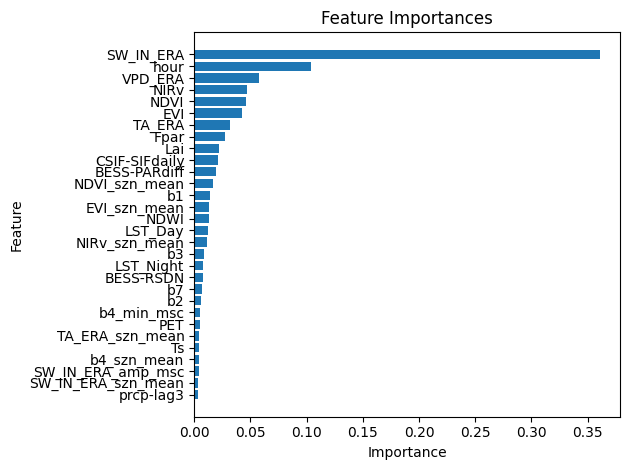

In [ ]:
# get the feature importances
importances = pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False)

# Visualize
importances_sorted = importances.sort_values(ascending=True)[-30:]

fig, ax = plt.subplots()
ax.barh(importances_sorted.index, importances_sorted.values)
ax.set_title('Feature Importances')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
fig.tight_layout()
plt.show()

In [ ]:
print(importances)

SW_IN_ERA        0.36083
hour             0.10370
VPD_ERA          0.05758
NIRv             0.04676
NDVI             0.04636
                   ...  
MODIS_PFT_ENF    0.00002
MODIS_IGBP_EBF   0.00001
c3c4_unknown     0.00000
MODIS_IGBP_CSH   0.00000
MODIS_IGBP_WET   0.00000
Length: 94, dtype: float64


In [ ]:
importances_df = pd.DataFrame(importances).reset_index()
importances_df.columns = ["feature_name","importance"]
importances_df["importance"][:13].sum()

0.8102959038876457

## Evaluate RFR on Val & Test Set

In [ ]:
# # Predict on val/test sets
# y_pred_val = model_pkl.predict(X_val)
# y_pred_test = model_pkl.predict(X_test)

# # Evaluate predictions - VAL
# rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
# mae = mean_absolute_error(y_val, y_pred_val)
# r2 = r2_score(y_val, y_pred_val)
# print(f"Val RMSE: {rmse}")
# print(f"Val MAE: {mae}")
# print(f"Val R2/NSE: {r2}")

# Dimensionality Reduction

In [ ]:
def RFR_fit_show_result(model, X_train, y_train, X_val, y_val, feature_list, model_name):
  X_train = X_train[feature_list]
  y_train = y_train
  X_val = X_val[feature_list]
  y_val = y_val
  
  model.fit(X_train, y_train)
  # Predict on val/test sets
  y_pred_val = model.predict(X_val)
  # y_pred_test = model.predict(X_test)

  # Evaluate predictions - VAL
  rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
  mae = mean_absolute_error(y_val, y_pred_val)
  r2 = r2_score(y_val, y_pred_val)
  print(f"   ")
  print(f"{model_name}, Val RMSE: {rmse}, Val MAE: {mae}, Val R2/NSE: {r2}")
  return [model_name, feature_list, rmse, mae, r2]

In [ ]:
model_1, model_2, model_3, model_4, model_5 = [],[],[],[],[]
model_6, model_7, model_8, model_9, model_10 = [],[],[],[],[]

num_feature_list = [10, 12, 14, 16, 18, 20, 22, 25, 30, 35]
importance_total = importances_df["importance"][:13].sum()

list(importances_df["feature_name"][:13])

['SW_IN_ERA',
 'hour',
 'VPD_ERA',
 'NIRv',
 'NDVI',
 'EVI',
 'TA_ERA',
 'Fpar',
 'Lai',
 'CSIF-SIFdaily',
 'BESS-PARdiff',
 'NDVI_szn_mean',
 'b1']

In [ ]:
num_feature = 10
feature_list = list(importances_df["feature_name"][:num_feature])
feature_list

['SW_IN_ERA',
 'hour',
 'VPD_ERA',
 'NIRv',
 'NDVI',
 'EVI',
 'TA_ERA',
 'Fpar',
 'Lai',
 'CSIF-SIFdaily']

In [ ]:
importances_df["feature_name"].shape

(94,)

In [ ]:
model_list = [["model_name", "feature_list", "RMSE", "MAE", "R2"]]
model_name_list = ["model_1", "model_2", "model_3", "model_4", "model_5", 
              "model_6", "model_7", "model_8", "model_9", "model_10", 
              "model_11", "model_12", "model_13", "model_14", "model_15"]
num_feature_list = [3, 5, 7, 10, 12, 14, 16, 18, 20, 22, 25, 30, 35, 50, 90]

for idx, num_feature in enumerate(num_feature_list):
  feature_list = list(importances_df["feature_name"][:num_feature])
  model_name = model_name_list[idx]
  model_list += [RFR_fit_show_result(model, X_train, y_train, X_val, y_val, feature_list, model_name)]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.4s finished


   
model_1, Val RMSE: 5.52138744384949, Val MAE: 3.2094065275957027, Val R2/NSE: 0.42746178931715895


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_2, Val RMSE: 3.621476786666066, Val MAE: 2.0217146809382225, Val R2/NSE: 0.7536914762230129


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_3, Val RMSE: 3.5837865520363006, Val MAE: 1.9915562279762076, Val R2/NSE: 0.7587916706097189


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_4, Val RMSE: 3.5948660706926847, Val MAE: 2.001794608799337, Val R2/NSE: 0.7572979414430955


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_5, Val RMSE: 3.6051838024087677, Val MAE: 2.0072484689993497, Val R2/NSE: 0.7559027693985813


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_6, Val RMSE: 3.6223315400145513, Val MAE: 2.017037166854044, Val R2/NSE: 0.7535751933399648


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_7, Val RMSE: 3.61070837408951, Val MAE: 2.015813674043955, Val R2/NSE: 0.7551540886294615


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_8, Val RMSE: 3.624763829303129, Val MAE: 2.0258641412488854, Val R2/NSE: 0.7532441481869245


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_9, Val RMSE: 3.6231792579152877, Val MAE: 2.0295305649642965, Val R2/NSE: 0.7534598404732845


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_10, Val RMSE: 3.638509748917348, Val MAE: 2.0451750591627604, Val R2/NSE: 0.7513690922324698


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_11, Val RMSE: 3.6717808127363183, Val MAE: 2.0582658885736977, Val R2/NSE: 0.7468012682921942


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_12, Val RMSE: 3.6738487946260228, Val MAE: 2.08003764958367, Val R2/NSE: 0.7465159801066749


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_13, Val RMSE: 3.679013409870923, Val MAE: 2.086391606279179, Val R2/NSE: 0.7458027947297341


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   45.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_14, Val RMSE: 3.7343505548707285, Val MAE: 2.1189821144597727, Val R2/NSE: 0.7380983720434989


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


   
model_15, Val RMSE: 3.8818803615209996, Val MAE: 2.28402534205913, Val R2/NSE: 0.7169961637261888


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


In [ ]:
dimensionality_reduction_RFR_df = pd.DataFrame(model_list[1:], columns=model_list[0])
dimensionality_reduction_RFR_df["num_of_feature"] = num_feature_list

In [ ]:
dimensionality_reduction_RFR_df =dimensionality_reduction_RFR_df[['model_name', 'num_of_feature','feature_list', 'RMSE', 'MAE', 'R2']]
dimensionality_reduction_RFR_df

,model_name,num_of_feature,feature_list,RMSE,MAE,R2
0,model_1,3,"[SW_IN_ERA, hour, VPD_ERA]",5.52139,3.20941,0.42746
1,model_2,5,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI]",3.62148,2.02171,0.75369
2,model_3,7,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI, EVI, TA...",3.58379,1.99156,0.75879
3,model_4,10,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI, EVI, TA...",3.59487,2.00179,0.75730
4,model_5,12,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI, EVI, TA...",3.60518,2.00725,0.75590
5,model_6,14,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI, EVI, TA...",3.62233,2.01704,0.75358
6,model_7,16,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI, EVI, TA...",3.61071,2.01581,0.75515
7,model_8,18,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI, EVI, TA...",3.62476,2.02586,0.75324
8,model_9,20,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI, EVI, TA...",3.62318,2.02953,0.75346
9,model_10,22,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI, EVI, TA...",3.63851,2.04518,0.75137


In [ ]:
model_list_2 = [["model_name", "feature_list", "RMSE", "MAE", "R2"]]
model_name_list = ["model_2", "model2_2", "model_3", "model_3_2", "model_3_3","model_4"]#, 
              # "model_6", "model_7", "model_8", "model_9", "model_10", 
              # "model_11", "model_12", "model_13", "model_14", "model_15"]
num_feature_list = [5, 6 , 7, 8, 9, 10]

for idx, num_feature in enumerate(num_feature_list):
  feature_list = list(importances_df["feature_name"][:num_feature])
  model_name = model_name_list[idx]
  model_list_2 += [RFR_fit_show_result(model, X_train, y_train, X_val, y_val, feature_list, model_name)]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_2, Val RMSE: 3.621476786666066, Val MAE: 2.0217146809382225, Val R2/NSE: 0.7536914762230129


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model2_2, Val RMSE: 3.619276846252095, Val MAE: 2.022805911521489, Val R2/NSE: 0.7539906356678721


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_3, Val RMSE: 3.5837865520363006, Val MAE: 1.9915562279762076, Val R2/NSE: 0.758791670609719


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_3_2, Val RMSE: 3.600952005511753, Val MAE: 2.0082941602606517, Val R2/NSE: 0.7564754800868392


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


   
model_3_3, Val RMSE: 3.5922364126835724, Val MAE: 1.9976995384708645, Val R2/NSE: 0.7576528865053909


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


   
model_4, Val RMSE: 3.5948660706926847, Val MAE: 2.001794608799337, Val R2/NSE: 0.7572979414430955


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


In [ ]:
dimensionality_reduction_RFR_df_2 = pd.DataFrame(model_list_2[1:], columns=model_list_2[0])
dimensionality_reduction_RFR_df_2["num_of_feature"] = num_feature_list
dimensionality_reduction_RFR_df_2

,model_name,feature_list,RMSE,MAE,R2,num_of_feature
0,model_2,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI]",3.62148,2.02171,0.75369,5
1,model2_2,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI, EVI]",3.61928,2.02281,0.75399,6
2,model_3,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI, EVI, TA...",3.58379,1.99156,0.75879,7
3,model_3_2,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI, EVI, TA...",3.60095,2.00829,0.75648,8
4,model_3_3,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI, EVI, TA...",3.59224,1.99770,0.75765,9
5,model_4,"[SW_IN_ERA, hour, VPD_ERA, NIRv, NDVI, EVI, TA...",3.59487,2.00179,0.75730,10


# Build model with TOP7 features and store the model to pickle

In [23]:
feature_list = ['SW_IN_ERA', 'hour', 'VPD_ERA', 'NIRv', 'NDVI', 'EVI', 'TA_ERA']

In [25]:
X_train = X_train[feature_list]
X_val = X_val[feature_list]

model_top7 = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1, verbose=1)
model_top7.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.9s finished


RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=50,
                      n_jobs=-1, random_state=42, verbose=1)

In [28]:
# Predict on val/test sets
y_pred_val = model_top7.predict(X_val)

# Evaluate predictions - VAL
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print(f"Val RMSE: {rmse}, Val MAE: {mae}, Val R2/NSE: {r2}")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s


Val RMSE: 3.5837865520363006, Val MAE: 1.9915562279762076, Val R2/NSE: 0.7587916706097189


[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.3s finished


In [32]:
model_objects_dir

'/content/drive/MyDrive/TFT_baseline/code/src/modeling/model_objects'

In [43]:
import pickle
import joblib

# Save model object
model_save_path_pkl = os.path.join(model_objects_dir, 'rfr_mvp_v3_top7_features.pkl')
model_save_path_jl = os.path.join(model_objects_dir, 'rfr_mvp_v3_top7_features.joblib')
pickle.dump(model_top7, open(model_save_path_pkl, "wb"))

if not os.path.exists(model_save_path_jl):
    print("Saving model in .joblib format")
    joblib.dump(model_top7, model_save_path_jl)

In [44]:
# Re-load saved model
try:
    model_pkl = joblib.load(model_save_path_pkl)
    model_jl = joblib.load(model_save_path_jl)
    print("Loaded both model objects")
except:
    print("unable to load models, make sure object paths are correct and conda env in use")

Loaded both model objects


In [45]:
y_pred_val_trial = model_pkl.predict(X_val)
y_pred_val_trial

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.4s finished


array([-0.09666841, -0.06275384, -0.0656414 , ...,  1.59418392,
        1.59418392,  1.59418392])

## Get performance by IGBP type

In [40]:
# # Get categorical feature back from dummies
# igbp_cols = [x for x in test_df.columns if 'IGBP_' in x]
# test_df['MODIS_IGBP'] = test_df[igbp_cols].idxmax(axis=1)
# test_df['MODIS_IGBP'] = test_df['MODIS_IGBP'].apply(lambda x: x.split("_")[-1])

# # Subset df
# test_trim = test_df[['MODIS_IGBP', 'GPP_NT_VUT_REF']].copy()
# test_trim['y_pred'] = y_pred_test

# # Get metrics by group
# igbp_group_metrics = {}
# groups = test_df['MODIS_IGBP'].unique()
# for group in groups:
#     test_group = test_trim.loc[test_trim['MODIS_IGBP']==group, ].copy()
    
#     # Get metrics
#     rmse = np.sqrt(mean_squared_error(test_group['GPP_NT_VUT_REF'], test_group['y_pred']))
#     mae = mean_absolute_error(test_group['GPP_NT_VUT_REF'], test_group['y_pred'])
#     r2 = r2_score(test_group['GPP_NT_VUT_REF'], test_group['y_pred'])
    
#     # Save to dict
#     igbp_group_metrics[group] = {'RMSE': round(rmse, 2), 'MAE': round(mae, 2), 'R2': round(r2, 2)}
    
# igbp_metric_df = pd.DataFrame.from_dict(igbp_group_metrics, orient='index')
# igbp_metric_df = igbp_metric_df.reset_index().rename(columns={'index': 'MODIS_IGBP'})
# igbp_metric_df

In [41]:
# # compute the percentage of the dataset represented by each group
# group_sizes = test_trim.groupby('MODIS_IGBP').size()
# percentages = group_sizes / len(test_trim) * 100
# group_stats = test_trim.groupby('MODIS_IGBP')['GPP_NT_VUT_REF'].agg(['mean', 'var'])
# group_stats.columns = ['mean_GPP', 'var_GPP']
# group_stats['percent_dataset'] = percentages
# group_stats = group_stats.reset_index()

# merged_df = pd.merge(group_stats, igbp_metric_df, on='MODIS_IGBP')
# merged_df.sort_values('R2', ascending=False, inplace=True)
# merged_df